In [1]:
%load_ext autoreload
%autoreload 2
import networkx as nx

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"

import torch
import torch.nn as nn
from torch_geometric.data import DataLoader
import argparse
import numpy as np
import random
import ogb
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from graph_transformer import GT
from utils import pre_process, pre_process_with_summary, get_n_params, get_optimizer
import datetime
from tqdm import tqdm
from tensorboardX import SummaryWriter
import pytz


In [2]:
parser = argparse.ArgumentParser(description='PyTorch implementation of relative positional encodings and relation-aware self-attention for graph Transformers')
args = parser.parse_args("")

# args.dataset = 'ogbg-molbace'
args.dataset = 'ogbg-molhiv'
# args.dataset = 'ogbg-ppa'
args.n_classes = 1
args.lr = 2e-4
args.n_hid = 512
args.n_heads = 8
args.n_layer = 4
args.dropout = 0.2
args.num_epochs = 60
args.k_hop_neighbors = 3
args.weight_decay = 1e-2
args.bsz      = 128
args.strategies = ['lap', 'ea', 'sd']
args.summary_node = True
args.hier_levels = 3
args.lap_k = 10
args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", args.device)

device: cuda


In [3]:
print("Loading data...")
print("dataset: {} ".format(args.dataset))
tz = pytz.timezone('US/Pacific')
time_now = datetime.datetime.now(tz).strftime('%m-%d_%H:%M:%S')

if args.summary_node:
    pre_transform = lambda d : pre_process_with_summary(d, args)
    root_path= f'dataset/{args.dataset}/with_summary_{args.k_hop_neighbors}'
    args.writer = SummaryWriter(log_dir=f'runs_new/{args.dataset}/with_summary_k={args.k_hop_neighbors}/strats={"-".join(args.strategies)}/{time_now}')

else:
    pre_transform = lambda d : pre_process(d, args)
    root_path= f'dataset/{args.dataset}/{args.k_hop_neighbors}'
    args.writer = SummaryWriter(log_dir=f'runs_new/{args.dataset}/k={args.k_hop_neighbors}/strats={"-".join(args.strategies)}/{time_now}')
    
    
dataset = PygGraphPropPredDataset(name=args.dataset, pre_transform=pre_transform, root = root_path)
evaluator = Evaluator(name=args.dataset)
split_idx = dataset.get_idx_split()
edge_dim_dict = {'ea': dataset.data.edge_attr.max(dim=0)[0].int().view(-1) + 1, \
                 'sd': (dataset.data.sd_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
                 # 'cn': (dataset.data.cn_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
                 # 'hsd': (dataset.data.hsd_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
                # 'ja': dataset.data.jaccard_edge_attr.max(dim=0)[0].int().view(-1) + 1, \
                # 'ad': dataset.data.adamic_edge_attr.max(dim=0)[0].int().view(-1) + 1, \
                }
model = GT(args.n_hid, args.n_classes, args.n_heads, args.n_layer, edge_dim_dict, args.dropout, args.summary_node, args.lap_k).to(args.device)

Loading data...
dataset: ogbg-molhiv 


In [4]:
# Regular loader
# train_loader = DataLoader(dataset[split_idx["train"]], batch_size=args.bsz, shuffle=True)
# valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.bsz, shuffle=False)
# test_loader  = DataLoader(dataset[split_idx["test"]],  batch_size=args.bsz, shuffle=False)

In [5]:
# Loader with weighted sampler, for unbalanced data

from torch.utils.data import WeightedRandomSampler
weight = [1.0, np.sqrt((dataset.data.y == 0).sum().item() / (dataset.data.y == 1).sum().item())]
samples_weight = np.array([weight[yi] for yi in dataset.data.y.view(-1)[split_idx["train"]]])

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

train_loader = DataLoader(dataset[split_idx["train"]], batch_size=args.bsz, sampler = sampler)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.bsz, shuffle = False)
test_loader  = DataLoader(dataset[split_idx["test"]],  batch_size=args.bsz, shuffle = False)

In [6]:
print('Model #Params: %d' % get_n_params(model))

criterion = torch.nn.BCEWithLogitsLoss(reduction = "mean")

optimizer = get_optimizer(model, weight_decay = args.weight_decay)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, pct_start = 0.05,\
        steps_per_epoch=len(train_loader), epochs = args.num_epochs, anneal_strategy = 'linear')

Model #Params: 8542721


In [7]:
stats = []
for epoch in range(args.num_epochs):
    model.train()
    train_loss = []
    for num_iters, data in enumerate(tqdm(train_loader)):
        data.to(args.device)
        # strats = {'ea': data.edge_attr, 'cn': data.cn_edge_attr, 'sd': data.sd_edge_attr, 'hsd': data.hsd_edge_attr.long()}
        strats = {'ea': data.edge_attr, 'lap_x': data.lap_x, 'sd': data.sd_edge_attr}
        out = model(data.x, data.batch, data.edge_index, strats)
        loss = criterion(out, data.y.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        
        train_loss += [loss.item()]
        
    args.writer.add_scalar("LR/epoch", optimizer.param_groups[0]['lr'], epoch + 1)
    args.writer.add_scalar("Loss/train", np.average(train_loss), epoch + 1)

    model.eval()
    with torch.no_grad():
        valid_loss = []
        y_true = []
        y_scores = []
        for num_iters, data in enumerate(tqdm(valid_loader)):
            data.to(args.device)
            # strats = {'ea': data.edge_attr, 'cn': data.cn_edge_attr, 'sd': data.sd_edge_attr, 'hsd': data.hsd_edge_attr.long()}
            strats = {'ea': data.edge_attr, 'lap_x': data.lap_x, 'sd': data.sd_edge_attr}
            out = model(data.x, data.batch, data.edge_index, strats)
        
            loss = criterion(out, data.y.float())
            valid_loss += [loss.item()]

            y_true += [data.y]
            y_scores += [out]

        input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
        valid_rocauc = evaluator.eval(input_dict)['rocauc']
        args.writer.add_scalar("Loss/valid", np.average(valid_loss), epoch + 1)
        args.writer.add_scalar("ROC/valid", valid_rocauc, epoch + 1)
        
        test_loss = []
        y_true = []
        y_scores = []
        for data in test_loader:
            data.to(args.device)
            # strats = {'ea': data.edge_attr, 'cn': data.cn_edge_attr, 'sd': data.sd_edge_attr, 'hsd': data.hsd_edge_attr.long()}
            strats = {'ea': data.edge_attr, 'lap_x': data.lap_x, 'sd': data.sd_edge_attr}
            out = model(data.x, data.batch, data.edge_index, strats)
        
            loss = criterion(out, data.y.float())
            test_loss += [loss.item()]

            y_true += [data.y]
            y_scores += [out]

        input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
        test_rocauc = evaluator.eval(input_dict)['rocauc']
        args.writer.add_scalar("Loss/test", np.average(test_loss), epoch + 1)
        args.writer.add_scalar("ROC/test", test_rocauc, epoch + 1)
    
    print('Epoch %d: LR: %.5f, Train loss: %.3f Valid loss: %.3f  Valid ROC-AUC: %.3f Test loss: %.3f  Test ROC-AUC: %.3f' \
          % (epoch + 1, optimizer.param_groups[0]['lr'], np.average(train_loss), np.average(valid_loss), \
            valid_rocauc, np.average(test_loss), test_rocauc))
    stats += [[epoch, np.average(train_loss), np.average(valid_loss), valid_rocauc, np.average(test_loss), test_rocauc]]

args.writer.close()

  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 1: LR: 0.00007, Train loss: 0.431 Valid loss: 0.207  Valid ROC-AUC: 0.784 Test loss: 0.218  Test ROC-AUC: 0.753


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 2: LR: 0.00014, Train loss: 0.364 Valid loss: 0.091  Valid ROC-AUC: 0.769 Test loss: 0.120  Test ROC-AUC: 0.756


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 3: LR: 0.00020, Train loss: 0.321 Valid loss: 0.181  Valid ROC-AUC: 0.752 Test loss: 0.198  Test ROC-AUC: 0.730


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 4: LR: 0.00020, Train loss: 0.280 Valid loss: 0.107  Valid ROC-AUC: 0.790 Test loss: 0.146  Test ROC-AUC: 0.736


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 5: LR: 0.00019, Train loss: 0.217 Valid loss: 0.160  Valid ROC-AUC: 0.763 Test loss: 0.194  Test ROC-AUC: 0.742


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 6: LR: 0.00019, Train loss: 0.160 Valid loss: 0.107  Valid ROC-AUC: 0.808 Test loss: 0.161  Test ROC-AUC: 0.752


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 7: LR: 0.00019, Train loss: 0.125 Valid loss: 0.116  Valid ROC-AUC: 0.774 Test loss: 0.172  Test ROC-AUC: 0.737


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 8: LR: 0.00018, Train loss: 0.101 Valid loss: 0.103  Valid ROC-AUC: 0.802 Test loss: 0.172  Test ROC-AUC: 0.735


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 9: LR: 0.00018, Train loss: 0.085 Valid loss: 0.147  Valid ROC-AUC: 0.784 Test loss: 0.197  Test ROC-AUC: 0.759


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 10: LR: 0.00018, Train loss: 0.074 Valid loss: 0.111  Valid ROC-AUC: 0.779 Test loss: 0.177  Test ROC-AUC: 0.753


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 11: LR: 0.00017, Train loss: 0.065 Valid loss: 0.115  Valid ROC-AUC: 0.801 Test loss: 0.195  Test ROC-AUC: 0.761


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 12: LR: 0.00017, Train loss: 0.057 Valid loss: 0.125  Valid ROC-AUC: 0.773 Test loss: 0.201  Test ROC-AUC: 0.762


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 13: LR: 0.00016, Train loss: 0.054 Valid loss: 0.122  Valid ROC-AUC: 0.787 Test loss: 0.213  Test ROC-AUC: 0.743


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 14: LR: 0.00016, Train loss: 0.046 Valid loss: 0.124  Valid ROC-AUC: 0.806 Test loss: 0.227  Test ROC-AUC: 0.734


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 15: LR: 0.00016, Train loss: 0.044 Valid loss: 0.122  Valid ROC-AUC: 0.809 Test loss: 0.211  Test ROC-AUC: 0.751


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 16: LR: 0.00015, Train loss: 0.041 Valid loss: 0.127  Valid ROC-AUC: 0.798 Test loss: 0.217  Test ROC-AUC: 0.738


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 17: LR: 0.00015, Train loss: 0.040 Valid loss: 0.132  Valid ROC-AUC: 0.797 Test loss: 0.215  Test ROC-AUC: 0.756


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 18: LR: 0.00015, Train loss: 0.036 Valid loss: 0.132  Valid ROC-AUC: 0.782 Test loss: 0.217  Test ROC-AUC: 0.731


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 19: LR: 0.00014, Train loss: 0.032 Valid loss: 0.137  Valid ROC-AUC: 0.774 Test loss: 0.229  Test ROC-AUC: 0.737


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 20: LR: 0.00014, Train loss: 0.033 Valid loss: 0.118  Valid ROC-AUC: 0.797 Test loss: 0.199  Test ROC-AUC: 0.732


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 21: LR: 0.00014, Train loss: 0.031 Valid loss: 0.132  Valid ROC-AUC: 0.785 Test loss: 0.218  Test ROC-AUC: 0.727


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 22: LR: 0.00013, Train loss: 0.026 Valid loss: 0.142  Valid ROC-AUC: 0.792 Test loss: 0.221  Test ROC-AUC: 0.743


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 23: LR: 0.00013, Train loss: 0.024 Valid loss: 0.143  Valid ROC-AUC: 0.786 Test loss: 0.238  Test ROC-AUC: 0.736


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 24: LR: 0.00013, Train loss: 0.026 Valid loss: 0.138  Valid ROC-AUC: 0.793 Test loss: 0.231  Test ROC-AUC: 0.751


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 25: LR: 0.00012, Train loss: 0.024 Valid loss: 0.132  Valid ROC-AUC: 0.798 Test loss: 0.225  Test ROC-AUC: 0.760


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 26: LR: 0.00012, Train loss: 0.020 Valid loss: 0.141  Valid ROC-AUC: 0.793 Test loss: 0.234  Test ROC-AUC: 0.758


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 27: LR: 0.00012, Train loss: 0.021 Valid loss: 0.134  Valid ROC-AUC: 0.767 Test loss: 0.226  Test ROC-AUC: 0.753


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 28: LR: 0.00011, Train loss: 0.020 Valid loss: 0.136  Valid ROC-AUC: 0.779 Test loss: 0.224  Test ROC-AUC: 0.740


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 29: LR: 0.00011, Train loss: 0.018 Valid loss: 0.139  Valid ROC-AUC: 0.795 Test loss: 0.247  Test ROC-AUC: 0.733


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 30: LR: 0.00011, Train loss: 0.017 Valid loss: 0.147  Valid ROC-AUC: 0.814 Test loss: 0.253  Test ROC-AUC: 0.719


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 31: LR: 0.00010, Train loss: 0.017 Valid loss: 0.141  Valid ROC-AUC: 0.805 Test loss: 0.252  Test ROC-AUC: 0.739


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 32: LR: 0.00010, Train loss: 0.014 Valid loss: 0.160  Valid ROC-AUC: 0.789 Test loss: 0.255  Test ROC-AUC: 0.730


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 33: LR: 0.00009, Train loss: 0.013 Valid loss: 0.168  Valid ROC-AUC: 0.784 Test loss: 0.267  Test ROC-AUC: 0.734


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 34: LR: 0.00009, Train loss: 0.015 Valid loss: 0.157  Valid ROC-AUC: 0.785 Test loss: 0.267  Test ROC-AUC: 0.737


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 35: LR: 0.00009, Train loss: 0.013 Valid loss: 0.153  Valid ROC-AUC: 0.797 Test loss: 0.266  Test ROC-AUC: 0.733


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 36: LR: 0.00008, Train loss: 0.012 Valid loss: 0.159  Valid ROC-AUC: 0.784 Test loss: 0.269  Test ROC-AUC: 0.721


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 37: LR: 0.00008, Train loss: 0.011 Valid loss: 0.163  Valid ROC-AUC: 0.790 Test loss: 0.266  Test ROC-AUC: 0.745


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 38: LR: 0.00008, Train loss: 0.011 Valid loss: 0.150  Valid ROC-AUC: 0.760 Test loss: 0.246  Test ROC-AUC: 0.748


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 39: LR: 0.00007, Train loss: 0.009 Valid loss: 0.161  Valid ROC-AUC: 0.777 Test loss: 0.262  Test ROC-AUC: 0.746


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 40: LR: 0.00007, Train loss: 0.009 Valid loss: 0.171  Valid ROC-AUC: 0.783 Test loss: 0.272  Test ROC-AUC: 0.751


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 41: LR: 0.00007, Train loss: 0.007 Valid loss: 0.172  Valid ROC-AUC: 0.784 Test loss: 0.272  Test ROC-AUC: 0.736


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 42: LR: 0.00006, Train loss: 0.009 Valid loss: 0.173  Valid ROC-AUC: 0.779 Test loss: 0.269  Test ROC-AUC: 0.747


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 43: LR: 0.00006, Train loss: 0.008 Valid loss: 0.172  Valid ROC-AUC: 0.782 Test loss: 0.287  Test ROC-AUC: 0.721


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 44: LR: 0.00006, Train loss: 0.007 Valid loss: 0.170  Valid ROC-AUC: 0.789 Test loss: 0.285  Test ROC-AUC: 0.751


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 45: LR: 0.00005, Train loss: 0.007 Valid loss: 0.174  Valid ROC-AUC: 0.788 Test loss: 0.285  Test ROC-AUC: 0.732


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 46: LR: 0.00005, Train loss: 0.007 Valid loss: 0.173  Valid ROC-AUC: 0.782 Test loss: 0.282  Test ROC-AUC: 0.723


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 47: LR: 0.00005, Train loss: 0.006 Valid loss: 0.178  Valid ROC-AUC: 0.789 Test loss: 0.294  Test ROC-AUC: 0.713


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 48: LR: 0.00004, Train loss: 0.005 Valid loss: 0.183  Valid ROC-AUC: 0.778 Test loss: 0.290  Test ROC-AUC: 0.729


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 49: LR: 0.00004, Train loss: 0.004 Valid loss: 0.189  Valid ROC-AUC: 0.775 Test loss: 0.300  Test ROC-AUC: 0.728


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 50: LR: 0.00004, Train loss: 0.004 Valid loss: 0.185  Valid ROC-AUC: 0.779 Test loss: 0.296  Test ROC-AUC: 0.717


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 51: LR: 0.00003, Train loss: 0.004 Valid loss: 0.192  Valid ROC-AUC: 0.778 Test loss: 0.296  Test ROC-AUC: 0.719


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 52: LR: 0.00003, Train loss: 0.003 Valid loss: 0.189  Valid ROC-AUC: 0.792 Test loss: 0.302  Test ROC-AUC: 0.734


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 53: LR: 0.00002, Train loss: 0.003 Valid loss: 0.188  Valid ROC-AUC: 0.794 Test loss: 0.301  Test ROC-AUC: 0.728


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 54: LR: 0.00002, Train loss: 0.003 Valid loss: 0.191  Valid ROC-AUC: 0.792 Test loss: 0.304  Test ROC-AUC: 0.735


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 55: LR: 0.00002, Train loss: 0.003 Valid loss: 0.192  Valid ROC-AUC: 0.786 Test loss: 0.304  Test ROC-AUC: 0.731


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 56: LR: 0.00001, Train loss: 0.003 Valid loss: 0.191  Valid ROC-AUC: 0.792 Test loss: 0.306  Test ROC-AUC: 0.729


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 57: LR: 0.00001, Train loss: 0.002 Valid loss: 0.196  Valid ROC-AUC: 0.785 Test loss: 0.306  Test ROC-AUC: 0.729


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 58: LR: 0.00001, Train loss: 0.002 Valid loss: 0.196  Valid ROC-AUC: 0.781 Test loss: 0.307  Test ROC-AUC: 0.727


  0%|          | 0/258 [00:00<?, ?it/s]

Epoch 59: LR: 0.00000, Train loss: 0.003 Valid loss: 0.194  Valid ROC-AUC: 0.784 Test loss: 0.305  Test ROC-AUC: 0.728


100%|██████████| 33/33 [00:04<00:00,  7.18it/s]


Epoch 60: LR: -0.00000, Train loss: 0.002 Valid loss: 0.195  Valid ROC-AUC: 0.786 Test loss: 0.305  Test ROC-AUC: 0.727


[2.90000000e+01 1.72470997e-02 1.46622005e-01 8.14061581e-01
 2.52612878e-01 7.19332162e-01]


TypeError: annotate() missing 1 required positional argument: 's'

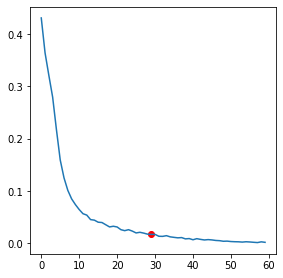

In [8]:
import matplotlib.pyplot as plt
labels = ['epoch', 'train_loss', 'valid_loss', 'valid_rocauc', 'test_loss', 'test_rocauc']
fig = plt.figure(figsize=(15, 10))
stats_np = np.array(stats)
best_valid = stats_np[stats_np[:, 3].argmax()]
print(best_valid)
for i in range(1, stats_np.shape[-1]):
    ax = fig.add_subplot(2, 3, i)
    ax.plot(stats_np[:, i], label=labels[i])
    ax.scatter(x=best_valid[0], y=best_valid[i], color='red')
    ax.annotate(text=best_valid[i].round(3), xy=(best_valid[0]+5, best_valid[i]), color='red')
    ax.legend()
